In [1]:
!pip install matplotlib
!pip install geopandas
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import re
import pandas as pd
import datetime
import matplotlib.pyplot as plt


graf_df = pd.read_csv("Parks_Graffiti_Report_-_Dataset.csv")
#rename the columns
graf_df = graf_df.rename(columns = {'Location Name':"location_name","Work Performed Date":"work_date","Location Address":"location_address","Issue":"issue",
                                    "Description":"descr","Labor Cost":"labor","Material Cost":"material","Total Cost":"total_cost","Location":"location"})
#add column of the month work is perfomed
graf_df['work_date'] = pd.to_datetime(graf_df['work_date'])
graf_df["work_month"] = graf_df.work_date.dt.strftime('%Y-%m')

null_data = graf_df[graf_df.isnull().any(axis=1)]
null_data.shape
#remove the entries with missing values from the dataset
graf_df = graf_df.dropna().reset_index()
graf_df.drop(columns = "index", inplace = True)
graf_df['work_year'] = graf_df.work_date.dt.year.apply(int)


In [2]:
#Manipulate the dataset to extract latitude and longtitude to draw scatter map and heatmaps
#extract latitutde and longitude from location data
lat = lambda x: float(re.search('.+,\s*',x).group().strip('(, '))
lon = lambda x: float(re.search(',\s*.+',x).group().strip('),'))

graf_df['lat'] = graf_df['location'].astype(str).apply(lat)

graf_df['lon'] = graf_df['location'].astype(str).apply(lon)

#reading the shapefile with district boundaries
crs = {'init':'epsg:3035'}
stpaul_shp = geopandas.read_file(r'geo_export_0bdcf90b-40ea-4ab1-89ff-1dcbe6c4b7dd.shp')
stpaul_shp.district = stpaul_shp.district.apply(int)
#add polygon center to the shapefile
stpaul_shp["center"] = stpaul_shp["geometry"].centroid

dist_points= stpaul_shp.copy()
dist_points.set_geometry("center", inplace = True)

#adding polygon to graf_df dataframe
poly = stpaul_shp.geometry
def geo_mat(xy):
    """function to return the string representation of polygon center based on off a polygon geoseries"""
    for i in poly:
        if xy.within(i):
            return str(i.centroid)

#add the center of polygon to graf_df set in order to merge the count of graffiti at each location with the district shapefile later
graf_df['points'] = pd.Series([Point(xy) for xy in zip(graf_df["lon"], graf_df['lat'])])
graf_df['geometry_center'] = graf_df.points.apply(geo_mat)



<ipython-input-2-9631a5a0ccbd>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stpaul_shp["center"] = stpaul_shp["geometry"].centroid


In [3]:
#add a "park" column to distinguish between graffiti found in park vs. non park
def is_park(name):
    """function to return true/false on a series if it's a park"""
    if re.search(' park',name.lower()) == None:
        return "Yes"
    else:
        return "No"
graf_df['is_park'] = graf_df.location_name.apply(is_park)
graf_df.head()
#reorder the dataframe
col = ['work_date','work_year','work_month','location_name','is_park','location_address','issue','descr','labor','material','total_cost','location','lat','lon','points','geometry_center']
graf_df = graf_df[col]
graf_df
   

,work_date,work_year,work_month,location_name,is_park,location_address,issue,descr,labor,material,total_cost,location,lat,lon,points,geometry_center
0,2014-07-11,2014,2014-07,Cayuga,Yes,198 Cayuga St.,Graffiti,Graffiti on the tolt lot,54.20,14.50,68.70,"(44.967, -93.092)",44.967000,-93.092000,POINT (-93.092 44.967),POINT (-93.10737839823319 44.97801270817757)
1,2014-03-31,2014,2014-03,Swede Hollow,Yes,651 Greenbrier St. E.,Graffiti,Graffiti on tunnel walls,60.35,78.31,138.66,"(44.9606, -93.0711)",44.960600,-93.071100,POINT (-93.0711 44.9606),POINT (-93.05934308156822 44.95585553670134)
2,2015-06-24,2015,2015-06,Crosby Regional Park,No,35 E & Sheppard Road,Graffiti,Graffiti on drinking fountain,27.10,10.00,37.10,"(44.910862, -93.1436462)",44.910862,-93.143646,POINT (-93.14364620000001 44.910862),POINT (-93.1258741437848 44.92634347084619)
3,2015-02-03,2015,2015-02,Lilydale Regional Park,No,400 Water St,Graffiti,"Graffiti in parking lots, and on pathways, signs",30.17,21.65,51.83,"(44.9202843, -93.1216736)",44.920284,-93.121674,POINT (-93.12167359999999 44.9202843),POINT (-93.07966444679558 44.93111813951181)
4,2013-09-24,2013,2013-09,Front Rec,Yes,485 Stinson St.,Graffiti,Graffiti in the mens room,81.30,46.08,127.38,"(44.9693, -93.1205)",44.969300,-93.120500,POINT (-93.12050000000001 44.9693),POINT (-93.10737839823319 44.97801270817757)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2014-05-06,2014,2014-05,Mattock Park,No,451 Macalester,Graffiti,Graffiti on picnic tables,57.27,13.68,70.96,"(44.9279, -93.1697)",44.927900,-93.169700,POINT (-93.16970000000001 44.9279),POINT (-93.17450997030703 44.93399042551741)
779,2013-06-27,2013,2013-06,Eastview Rec,Yes,1675 Fifth St. E.,Graffiti,Graffiti on electrical transformer and building,27.10,7.03,34.13,"(44.9596, -93.0296)",44.959600,-93.029600,POINT (-93.0296 44.9596),POINT (-93.02507390885717 44.92825760307291)
780,2014-10-01,2014,2014-10,Harriet Island Pav,Yes,200 Dr Justice Ohage Blvd,Graffiti,Graffiti on the levee wall entrance,81.30,46.75,128.05,"(44.9368, -93.0975)",44.936800,-93.097500,POINT (-93.0975 44.9368),POINT (-93.07966444679558 44.93111813951181)
781,2014-05-16,2014,2014-05,Eastvie Rec,Yes,1675 Fifth St. E.,Graffiti,Grsaffiti on the horse shoe courts and benches,27.10,12.25,39.35,"(44.9596, -93.0296)",44.959600,-93.029600,POINT (-93.0296 44.9596),POINT (-93.02507390885717 44.92825760307291)


C:\Users\Jude\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Jude\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


TypeError: 'AxesSubplot' object is not subscriptable

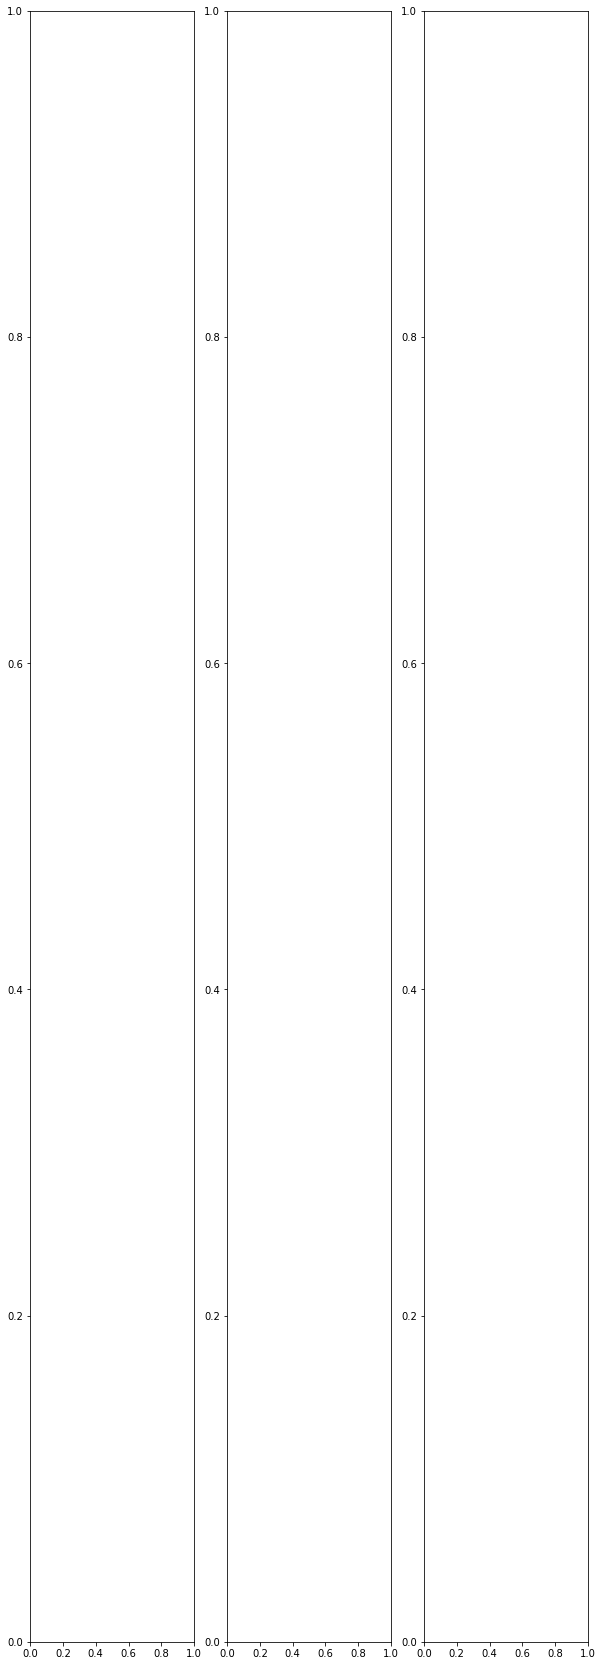

In [7]:
#crs = {'init':'epsg:4326'}
year = ['2013','2014','2015']
def graf_dots(year,park):
    """function to create geodataframes for each year to be used in drawing graffiti scatter maps"""
    location = graf_df[(graf_df.work_year.apply(int) == int(year)) & (graf_df.is_park == park)]
    points = location['points']
    geodata = geopandas.GeoDataFrame(location,crs=crs, geometry=points)
    return geodata

#plot graffiti location on a district map for each year 2013,2014,2015
fig, ax = plt.subplots(1,3,figsize=(10,30))
for i in range(0,3): 
    data_park = graf_dots(year[i],'Yes')
    data_non_park = graf_dots(year[i],'No')
    stpaul_shp.plot(ax=ax[0][i], facecolor='Grey', edgecolor='w',alpha=1,linewidth=1,cmap="Pastel2")
    plot1 = data_park.plot(ax=ax[0][i], color='red', markersize=10)
    plot2 = data_non_park.plot(ax=ax[0][i], color='blue', markersize=10)
    ax[0][i].axis('off')
    ax[0][i].set_title('Graffiti Removal '+ year[i], fontsize=12)
    ax[0][i].set_xlabel('Longitude', fontsize=10)
    ax[0][i].set_ylabel('Latitude', fontsize='medium')
    #append district number to the background district map
    texts =[]
    for x, y, label in zip(dist_points.geometry.x, dist_points.geometry.y, dist_points["district"]):
        texts.append(ax[0][i].text(x, y, label, fontsize = 8))

#save the plots to png
fig.savefig("Graffiti_removal_scatter_by_year.png")

C:\Users\Jude\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Jude\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


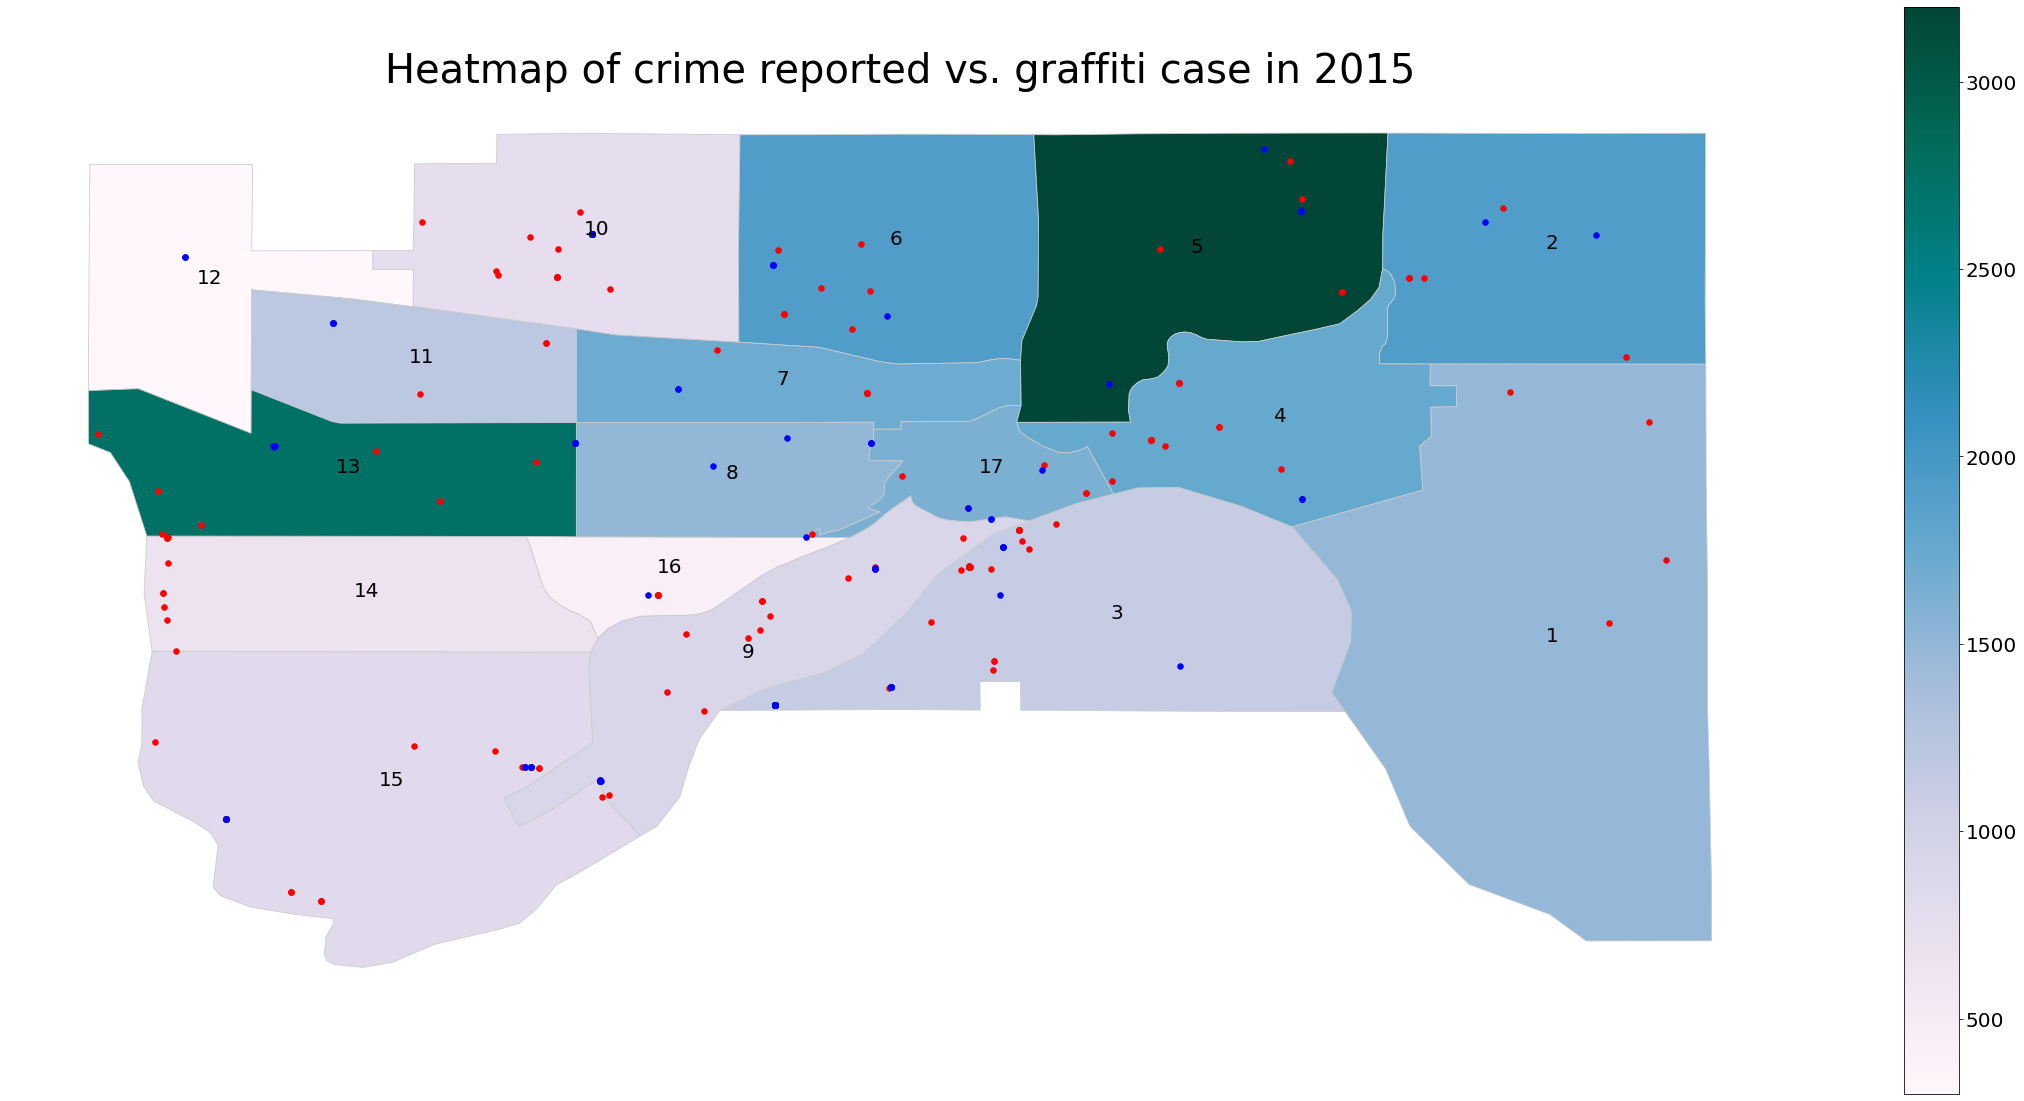

In [34]:
#Draw a crime rate heatmap for 2015 and show the graffiti scatter on it
#reading the crime dataset
crime_df = pd.read_csv("Crime_Incident_Report_-_Dataset.csv")
crime_df['year'] = pd.to_datetime(crime_df['DATE']).dt.year
#since the crime dataset starts in august 2014 and goes all the way to 2021, we only need 2015 data
crime_df = crime_df[crime_df.year == 2015]
crime_dist = crime_df.groupby('NEIGHBORHOOD NUMBER')['CASE NUMBER'].count().reset_index()

merged_crime = stpaul_shp.set_index('district').join(crime_dist.set_index('NEIGHBORHOOD NUMBER'))
merged_crime = merged_crime.reset_index()

#draw heatmap of crime rate in 2015
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heatmap of crime reported vs. graffiti case in 2015',fontsize = 40)

color = 'PuBuGn'
#max crime count is 3112, min is 353
vmin, vmax = 300, 3200
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

merged_crime.plot('CASE NUMBER', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

#plot the 2015 graffiti removal on the crime rate heatmap
graf_dots('2015','Yes').plot(ax=ax, color='red', markersize=30);
graf_dots('2015','No').plot(ax=ax, color='blue', markersize=30);
texts_2015 =[]
for x, y, label in zip(dist_points.geometry.x, dist_points.geometry.y, dist_points["district"]):
    texts_2015.append(ax.text(x, y, label, fontsize = 20))
fig.savefig("crime_heatmap_grafcase_2015.png")

In [35]:
#add district number to graf_df dataframe
stpaul_shp['center_str'] = stpaul_shp['center'].apply(str)
graf_joined = pd.merge(left=graf_df, right=stpaul_shp, left_on='geometry_center', right_on='center_str')

graf_joined.drop(columns = ['name2','center','center_str'],inplace = True)
graf_joined.head()
graf_joined.rename(columns={'name1':'dist_name'},inplace = True)
graf_joined.shape
#781 rows, as opposed to graf_df's original row of 783 the two locations outside of St.Paul's districts are removed
#graf_joined.groupby(['work_year','district'])['location_name'].count()

(781, 19)

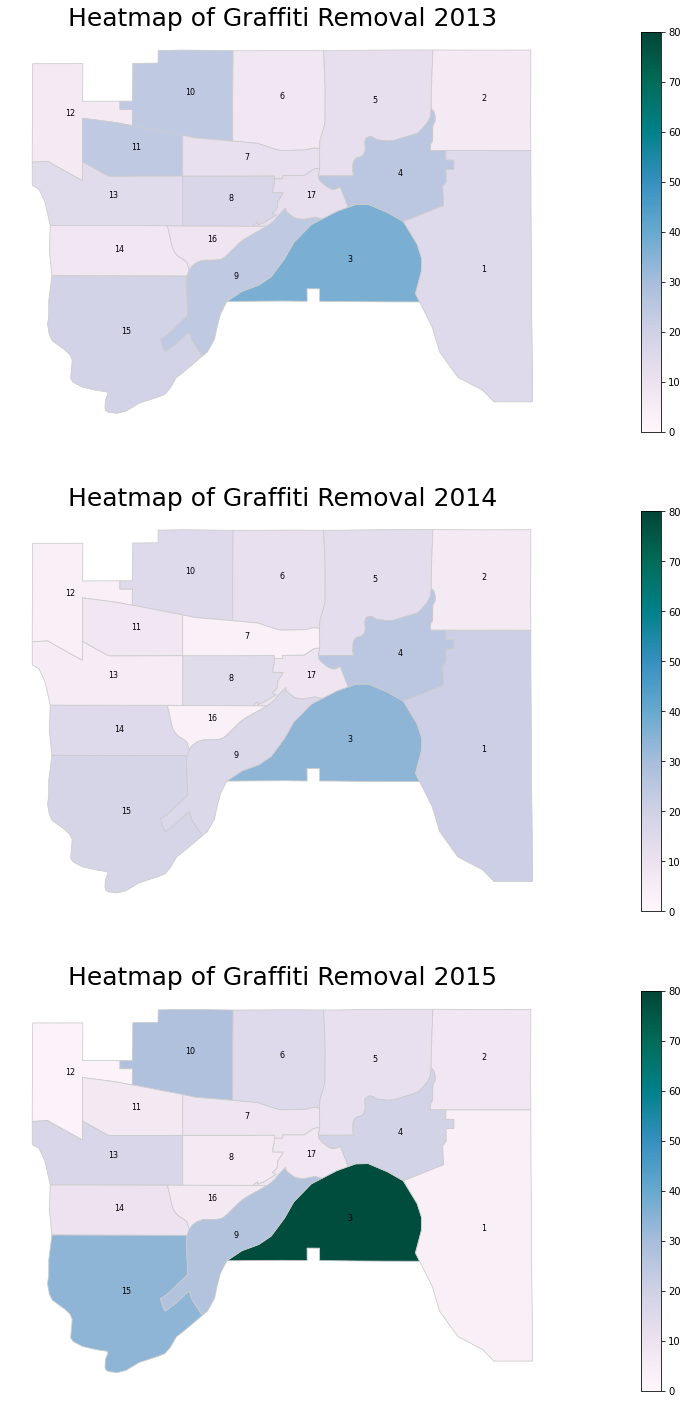

In [36]:
def heat_by_year(year):
    """function to build the shapefile for grafittie county that year"""
    graf_dist = graf_joined[graf_joined.work_year.apply(int) == int(year)].groupby('district')['location_name'].count()
    graf_shp = pd.merge(left=stpaul_shp, right= graf_dist, left_on='district', right_on='district')
    graf_shp.rename(columns = {'location_name':'graf_count_'+ year},inplace = True)
    return graf_shp


fig, ax = plt.subplots(3,1, figsize=(30, 25))

#year = ['2013','2014','2015']
for i in range(0,3): #draw a heat map for each year 2013,2014,2015
    data = heat_by_year(year[i])
    #draw the heatmap
    ax[i].axis('off')
    ax[i].set_title('Heatmap of Graffiti Removal '+ year[i],fontsize = 25)
    color = 'PuBuGn'
    col_name = 'graf_count_'+year[i]
    #range of graffiti removal at each district is 0-80 every year
    vmin, vmax = 0,80
    hmap = data.plot(col_name, cmap=color, vmin = vmin, vmax = vmax,linewidth=0.8, ax=ax[i], edgecolor='0.8', figsize=(40,20))
    #append district number to the background district map
    texts =[]
    for x, y, district in zip(data.center.x, data.center.y, data['district']) :
        texts.append(ax[i].text(x, y, district,fontsize = 8))
    #add colorbar 
    fig.colorbar(plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax)),ax = ax[i])

#save image to a png file    
fig.savefig('Heatmap_graf_removal_by_year.png')

In [37]:
dist_total = graf_joined.groupby(['district','work_year'])['descr'].count().unstack().T
dist_total['grand_total'] = dist_total.sum(axis = 1)
dist_total

district,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,grand_total
work_year,,,,,,,,,,,,,,,,,,
2013,15,6,37,25,12,8,11,17,24,24,24,6,14,8,19,9,12,271
2014,21,6,34,25,13,11,3,14,16,15,8,4,5,15,18,3,9,220
2015,4,8,78,19,11,15,9,6,27,28,7,2,17,10,34,7,8,290


In [9]:
#The following code section is from Mia
######################  descriptive plotting   #############################################################################################
!pip install seaborn
#!pip install wordcloud
!pip install nltk
import seaborn as sns
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.patches as mpatches
import nltk
nltk.download('popular')
from nltk.corpus import stopwords
from collections import Counter


#Dataframe code copied from above

#graf_df = pd.read_csv("Parks_Graffiti_Report_-_Dataset.csv")
##rename the columns
#graf_df = graf_df.rename(columns = {'Location Name':"location_name","Work Performed Date":"work_date","Location Address":"location_address","Issue":"issue",
#                                    "Description":"descr","Labor Cost":"labor","Material Cost":"material","Total Cost":"total_cost","Location":"location"})
#add column of the month work is perfomed
#graf_df['work_date'] = pd.to_datetime(graf_df['work_date'])
#graf_df["work_month"] = graf_df.work_date.dt.strftime('%Y-%m')
graf_df["work month without year"] = graf_df['work_date'].dt.month

#graf_df['work_year'] = graf_df.work_date.dt.year
#null_data = graf_df[graf_df.isnull().any(axis=1)]
#null_data.shape
#remove the entries with missing values from the dataset
#graf_df = graf_df.dropna().reset_index()


You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users

You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Please take a look at the wordcloud graph


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\in\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users

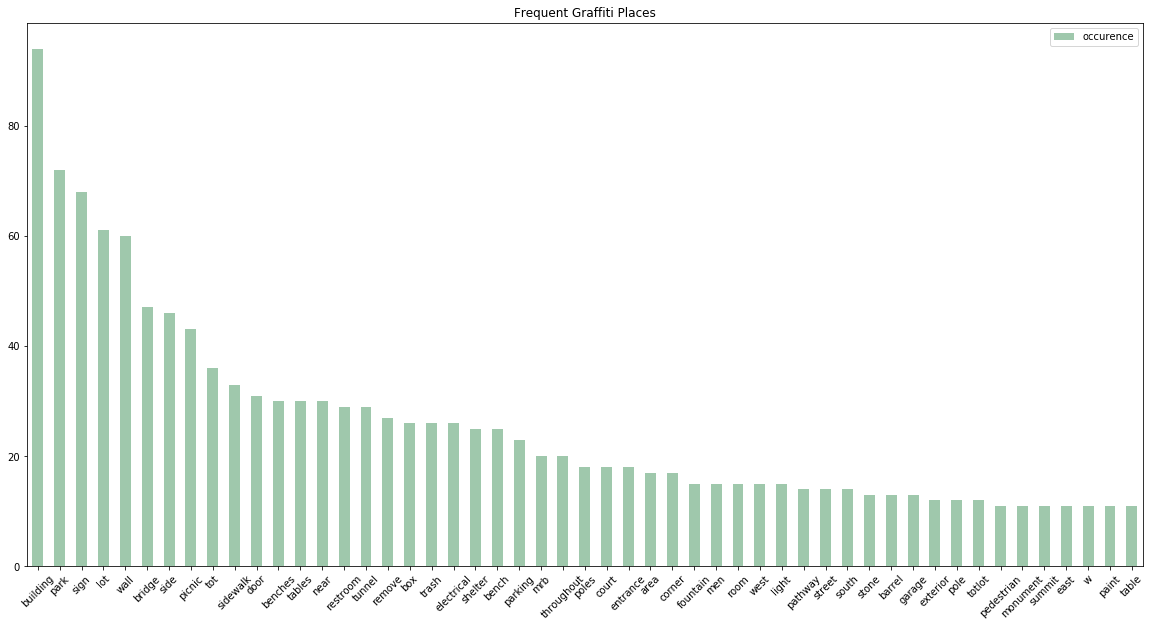

In [11]:
################ top 10 bubble of description column


description_list = graf_df['descr'].str.lower().str.replace(',', '').str.split(' ')

word_list = []
for x in description_list:
    for i in x:
        if i.endswith('s') and i.endswith('es') == False:
           i = i[:-1]
        word_list.append(i)
        


word_count = Counter(word_list)

sorted_word_count = sorted(word_count.items(), key=lambda item: item[1], reverse = True)

word_l = []
occurence_l = []
for x in sorted_word_count:
    word_l.append(x[0])
    occurence_l.append(x[1])


word_occurence = pd.DataFrame({'word': word_l, 'occurence': occurence_l})



import nltk
nltk.download('popular')
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))

  
filter_word = word_occurence[(~word_occurence['word'].isin(stopwords)) &
                             (word_occurence['occurence'] > 10) &
                             (word_occurence['word'].str.lower() != 'graffiti') &
                             (word_occurence['word'] != '')]  
filter_word = filter_word.sort_values(by = ['occurence'], ascending = False)

#plt.figure(figsize=(15,10))
#plt.bar(filter_word['word'], filter_word['occurence'], data = filter_word)


ax = filter_word.plot.bar(figsize=(20,10), color = '#9fc8ac')
ax.set_xticklabels(filter_word['word'], rotation = 45)
ax.set_title('Frequent Graffiti Places')
plt.show()


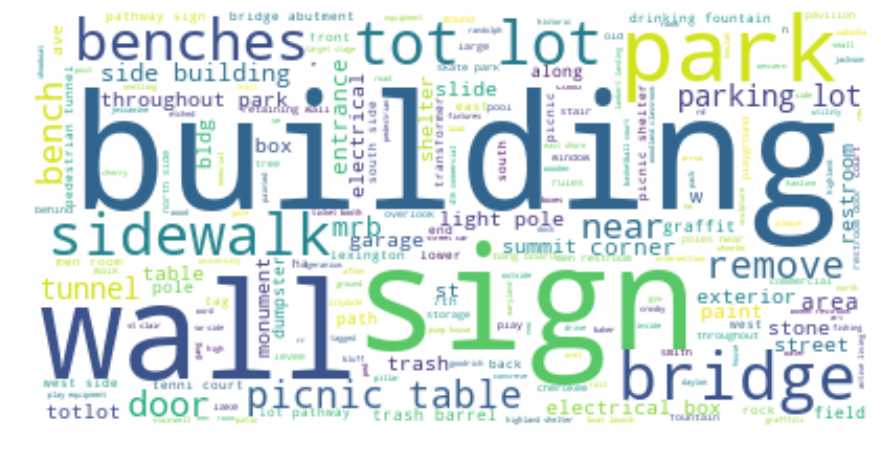

In [13]:
###### wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

word_list2 = [x + ' ' for x in word_list if x not in stopwords and x.lower() != 'graffiti']
string = ''.join(word_list2)
wordcloud = WordCloud(background_color="white").generate(string)

# Display the generated image:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



<ipython-input-9-fe4a981bc0ee>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels = incident_by_year_month['year_month'], rotation = 90, fontsize = 7)
<ipython-input-9-fe4a981bc0ee>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels = incident_by_year['year'],  fontsize = 12)


Text(0, 0.5, 'count')

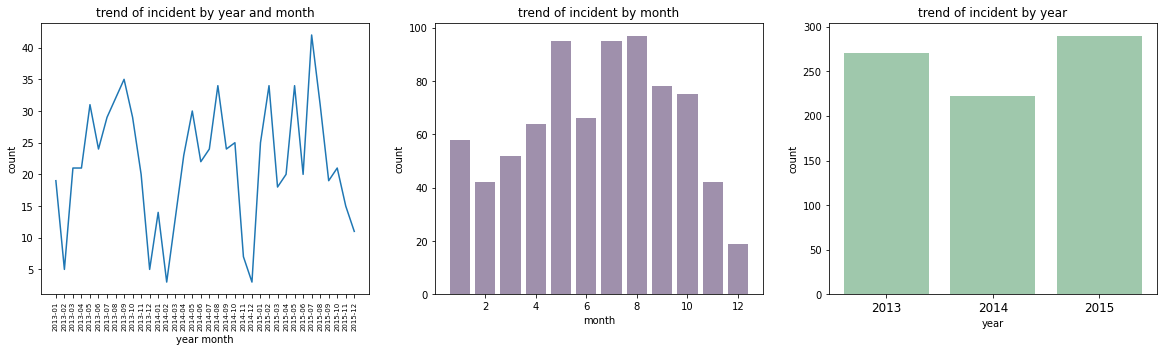

In [9]:
###################################################  plot

################ Incident by time

#prepare df

#by_time = graf_df.groupby("work_month").describe()
incident_by_year_month = graf_df.groupby("work_month").agg({'count'})
incident_by_year_month = incident_by_year_month.iloc[:,0].reset_index()
incident_by_year_month.columns = ['year_month', 'count']

incident_by_month = graf_df.groupby("work month without year").agg({'count'})
incident_by_month = incident_by_month.iloc[:,0].reset_index()
incident_by_month.columns = ['month', 'count']

incident_by_year = graf_df.groupby("work_year").agg({'count'})
incident_by_year = incident_by_year.iloc[:,0].reset_index()
incident_by_year.columns = ['year', 'count']
incident_by_year['year'] = incident_by_year['year'].astype(int).astype(str)
##incident_by_year_month['index']

#plotting
fig, ax = plt.subplots(1,3,figsize = (20,5))
ax[0].plot(incident_by_year_month['year_month'], incident_by_year_month['count'])
ax[1].bar(incident_by_month['month'], incident_by_month['count'], color = '#9f90ac')
ax[2].bar(incident_by_year['year'], incident_by_year['count'], color = '#9fc8ac')
  
  
ax[0].set_title('trend of incident by year and month')
ax[0].set_xticklabels(labels = incident_by_year_month['year_month'], rotation = 90, fontsize = 7)
ax[0].set_xlabel('year month')
ax[0].set_ylabel('count')

ax[1].set_title('trend of incident by month')
#ax[1].set_xticklabels(labels = incident_by_month['month'], fontsize = 10)
ax[1].set_xlabel('month')
ax[1].set_ylabel('count')

ax[2].set_title('trend of incident by year')
ax[2].set_xticklabels(labels = incident_by_year['year'],  fontsize = 12)
ax[2].set_xlabel('year')
ax[2].set_ylabel('count')

<ipython-input-10-a957615b8b97>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(cost_by_year_month.index, rotation = 90, fontsize = 7)
<ipython-input-10-a957615b8b97>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels = cost_by_year['work_year'],  fontsize = 12)


Text(0, 0.5, 'total cost')

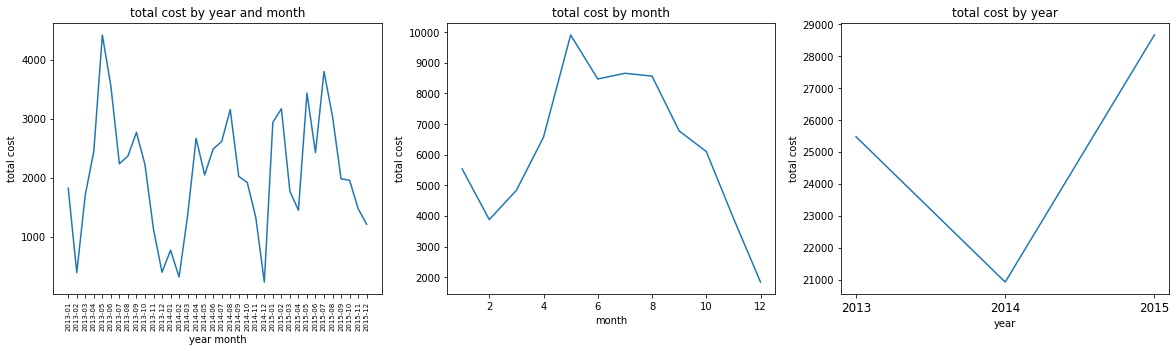

In [10]:
################ cost by time

cost_by_year_month = graf_df['total_cost'].groupby(graf_df["work_month"] ).sum()
cost_by_month = graf_df['total_cost'].groupby(graf_df["work month without year"] ).sum()
cost_by_year = graf_df['total_cost'].groupby(graf_df["work_year"] ).sum().reset_index()
cost_by_year['work_year'] = cost_by_year['work_year'].astype(int).astype(str)


fig, ax = plt.subplots(1,3,figsize = (20,5))
ax[0].plot(cost_by_year_month.index, cost_by_year_month)
ax[1].plot(cost_by_month.index, cost_by_month)
ax[2].plot(cost_by_year['work_year'], cost_by_year['total_cost'])


ax[0].set_title('total cost by year and month')
ax[0].set_xticklabels(cost_by_year_month.index, rotation = 90, fontsize = 7)
ax[0].set_xlabel('year month')
ax[0].set_ylabel('total cost')

ax[1].set_title('total cost by month')
#ax[1].set_xticklabels(labels = cost_by_month.index, fontsize = 10)
ax[1].set_xlabel('month')
ax[1].set_ylabel('total cost')

ax[2].set_title('total cost by year')
ax[2].set_xticklabels(labels = cost_by_year['work_year'],  fontsize = 12)
ax[2].set_xlabel('year')
ax[2].set_ylabel('total cost')

<ipython-input-14-2ad3723feaf4>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(LMcost_by_year_month.index, rotation = 90, fontsize = 7)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
<ipython-input-14-2ad3723feaf4>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(labels = LMcost_by_year['work_year'],  fontsize = 12)


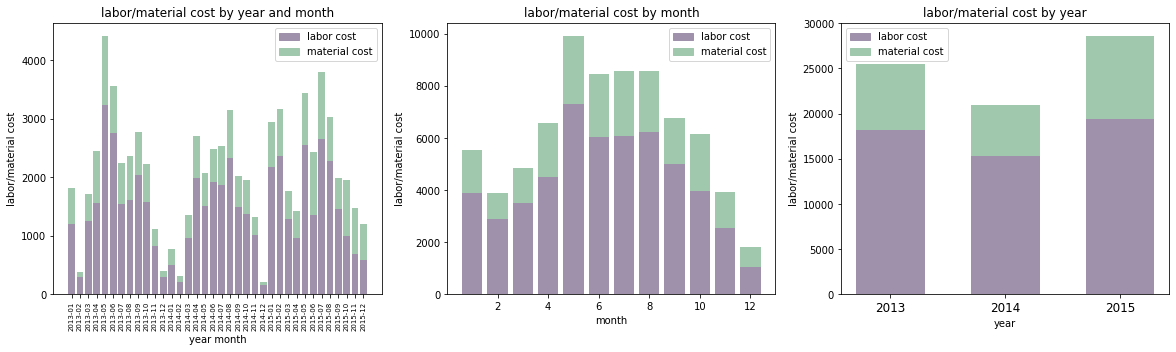

In [14]:
################ labor vs material cost

LMcost_by_year_month = graf_df[['labor', 'material']].groupby(graf_df["work_month"] ).sum()
LMcost_by_month = graf_df[['labor', 'material']].groupby(graf_df["work month without year"] ).sum()
LMcost_by_year = graf_df[['labor', 'material']].groupby(graf_df["work_year"] ).sum().reset_index()
LMcost_by_year['work_year'] = LMcost_by_year['work_year'].astype(int).astype(str)


fig, ax = plt.subplots(1,3,figsize = (20,5))
ax[0].bar(LMcost_by_year_month.index, LMcost_by_year_month['labor'], color = '#9f90ac')                                                  
ax[0].bar(LMcost_by_year_month.index, LMcost_by_year_month['material'], bottom = LMcost_by_year_month['labor'], color = '#9fc8ac')

ax[1].bar(LMcost_by_month.index, LMcost_by_month['labor'], color = '#9f90ac')                                                  
ax[1].bar(LMcost_by_month.index, LMcost_by_month['material'], bottom = LMcost_by_month['labor'], color = '#9fc8ac')

ax[2].bar(LMcost_by_year['work_year'], LMcost_by_year['labor'], color = '#9f90ac', width = .6)                                                  
ax[2].bar(LMcost_by_year['work_year'], LMcost_by_year['material'], bottom = LMcost_by_year['labor'], color = '#9fc8ac', width = .6)

ax[0].set_title('labor/material cost by year and month')
ax[0].set_xticklabels(LMcost_by_year_month.index, rotation = 90, fontsize = 7)
ax[0].set_xlabel('year month', fontsize = 10)
ax[0].set_ylabel('labor/material cost')
ax[0].legend(loc ='upper center') 


ax[1].set_title('labor/material cost by month')
#ax[1].set_xticklabels(labels = range(1,13), fontsize = 10) #labels = LMcost_by_month.index.to_list()
ax[1].set_xlabel('month')
ax[1].set_xlabel('month')
ax[1].set_ylabel('labor/material cost')
ax[1].legend()

ax[2].set_title('labor/material cost by year')
ax[2].set_xticklabels(labels = LMcost_by_year['work_year'],  fontsize = 12)
ax[2].set_xlabel('year')
ax[2].set_ylabel('labor/material cost')


labor = mpatches.Patch(color='#9f90ac', label='labor cost')
material = mpatches.Patch(color='#9fc8ac', label='material cost')                      
ax[0].legend(handles=[labor, material])
ax[1].legend(handles=[labor, material])
ax[2].legend(handles=[labor, material])




Text(0, 0.5, 'total cost')

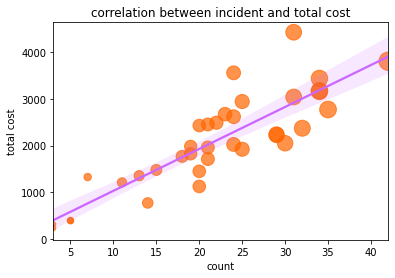

In [13]:
####################### correlation between incident and total cost
incident_by_year_month.columns
cost_by_year_month2 = cost_by_year_month.reset_index()
cost_count = pd.merge(left = incident_by_year_month, right = cost_by_year_month2, how = 'inner', left_on = 'year_month', right_on = 'work_month')



sns.regplot(x=cost_count['count'],
            y=cost_count['total_cost'], 
            scatter_kws={'color': '#ff6600', 's':cost_count['count'] * 8, 'alpha': 0.7},
            line_kws={'color': '#cc66ff'},
            data=cost_count)
plt.title('correlation between incident and total cost')
plt.ylabel('total cost')


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlable'

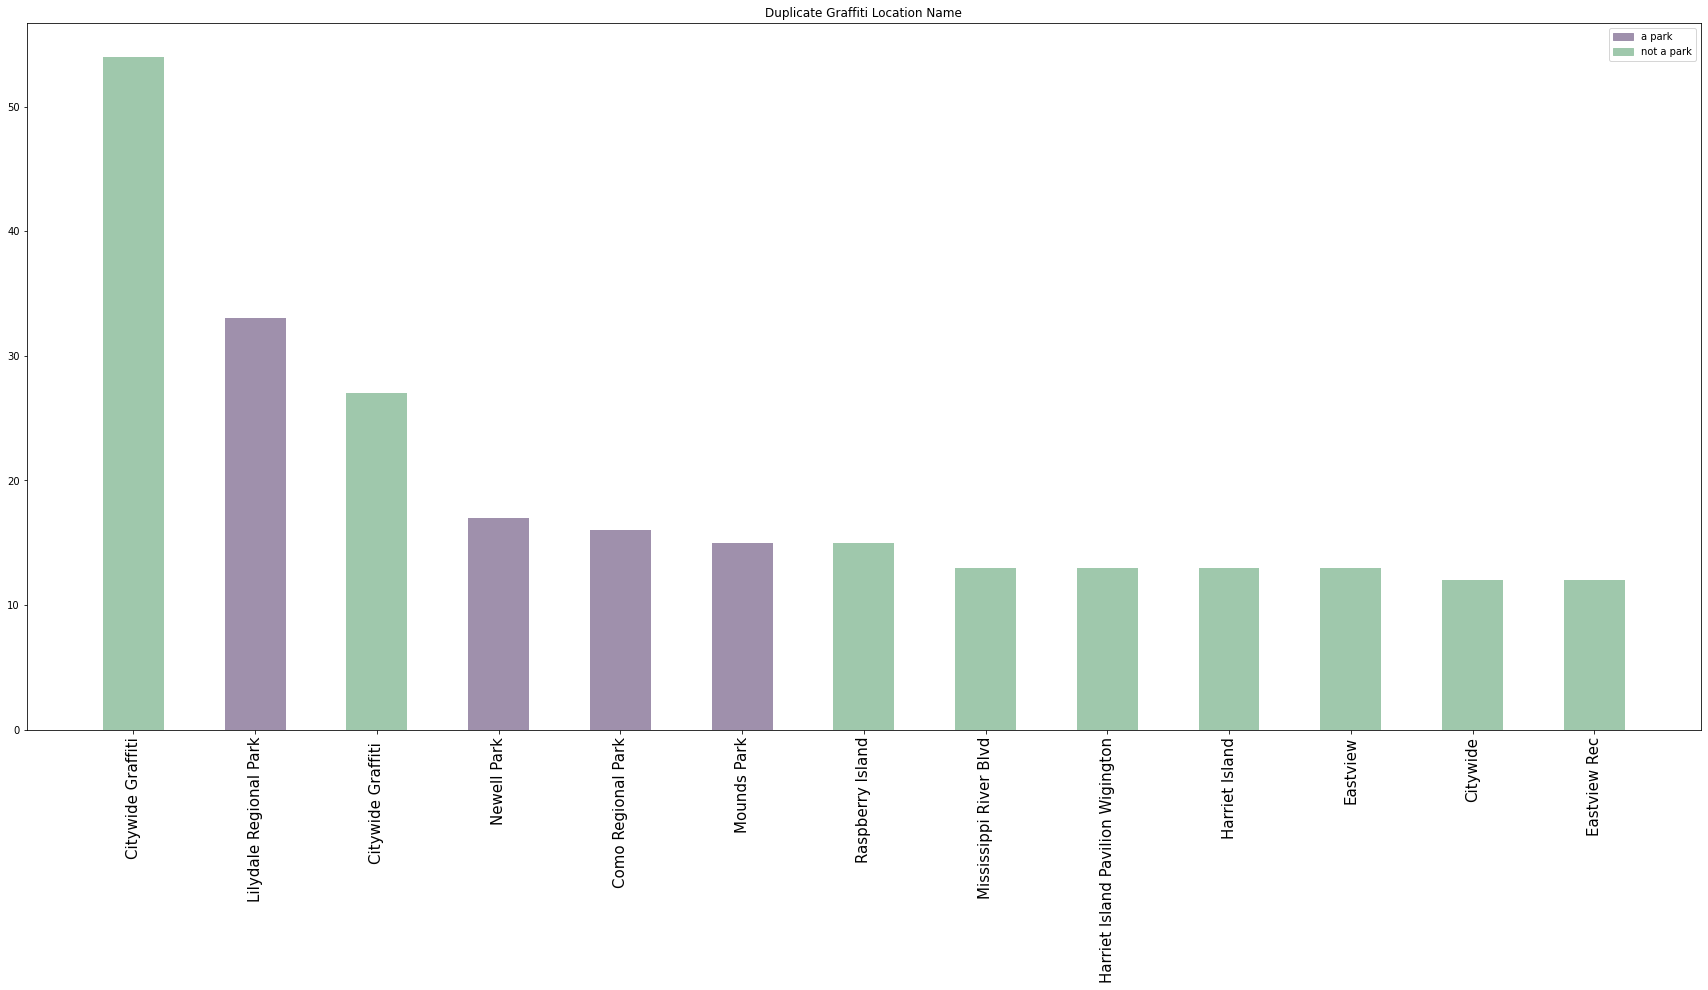

In [12]:
####################### duplicate_location (park/not park)
duplicate_location = graf_df['location_name'].value_counts().reset_index()
duplicate_location.columns = ['location name', 'count']

colors = []
for x in duplicate_location['location name']:
    if bool(re.match(r".*park", x.lower())):
        colors.append('#9f90ac')
    else:
        colors.append('#9fc8ac')
 
duplicate_location2 = duplicate_location[duplicate_location['count'] > 10]
duplicate_location2 = duplicate_location2.sort_values(by = ['count'], ascending = False)
plt.figure(figsize=(30,13))
plt.bar(duplicate_location2['location name'], duplicate_location2['count'], color = colors, width = .5)
plt.xticks(rotation = 90, fontsize = 15)


park = mpatches.Patch(color='#9f90ac', label='a park')
nopark = mpatches.Patch(color='#9fc8ac', label='not a park')                      
plt.legend(handles=[park, nopark])
plt.title('Duplicate Graffiti Location Name')
plt.xlable('location name')
plt.ylabel('count')